# 1. Import

In [108]:
from basic_functions import data_load, evaluate_model, save_df
import pandas as pd
import numpy as np


In [109]:
#Load Datasets
X_train = data_load("data/X_train.csv")
y_train = data_load("data/y_train_clustered.csv")

Data loaded!
Data loaded!


# 2. CategoricalNB

## 2.1 Initial model Pipeline

In [110]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.impute import SimpleImputer


pipe_catnb = Pipeline(steps=[
    ("oe", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)),
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("nb", CategoricalNB())
])

### 2.1.1 Gridsearch & Cross Validate Function

In [111]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1_macro": make_scorer(f1_score, average="macro"),
    "neg_log_loss": "neg_log_loss"
}

def run_gridsearch(pipe, param_grid, X, y, name):
    gs = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=cv,
        n_jobs=-1,
        refit=True
    )

    gs.fit(X, y)
    print(f"{name} best params: {gs.best_params_} | best f1: {gs.best_score_:.4f}")
    return gs


In [112]:
from sklearn.model_selection import cross_validate

def calculate_cv(pipeline, X, y, cv, scoring, show_results = True):

    cv_results   = cross_validate(pipeline, X.astype("category"), y, cv=cv, scoring=scoring)
    
    if show_results:
        for metric in scoring.keys():
            mean = cv_results[f"test_{metric}"].mean()
            std = cv_results[f"test_{metric}"].std()
            print(f"{metric}: {mean:.4f} ± {std:.4f}")

    return cv_results

In [113]:
_ = calculate_cv(pipeline=pipe_catnb, X= X_train, y=y_train["income"], cv=cv, scoring=scoring)

accuracy: 0.4179 ± 0.0048
f1_macro: 0.3686 ± 0.0059
neg_log_loss: -1.5494 ± 0.0210


In [114]:
param_grid = {
    "nb__alpha": [1e-3, 1e-2, 0.05, 0.1, 0.3, 1.0, 3.0, 10.0]
}
gs_catnb = run_gridsearch(pipe=pipe_catnb, param_grid=param_grid, X= X_train, y=y_train["income"], name="CatNB")

CatNB best params: {'nb__alpha': 0.001} | best f1: 0.3786


In [115]:
_ = calculate_cv(gs_catnb.best_estimator_, X_train, y_train["income"], cv, scoring)

accuracy: 0.4215 ± 0.0041
f1_macro: 0.3786 ± 0.0043
neg_log_loss: -1.6018 ± 0.0255


## Evaluation on Test Data

In [116]:
df_evaluation = {}

In [117]:
X_test = data_load("data/X_test.csv")
y_test = data_load("data/y_test_clustered.csv")

y_pred_catnb = gs_catnb.predict(X_test)
y_probs_catnb = gs_catnb.predict_proba(X_test)

Data loaded!
Data loaded!


In [118]:
catnb_eval = evaluate_model(y_pred=y_pred_catnb, y_test=y_test, model_name="CategoricalNB", y_proba=y_probs_catnb)

CategoricalNB:
Accuracy: 0.4108387677085676
Macro-F1: 0.3700812842156659
Weighted-F1: 0.3931453977091996
Log-Loss: 1.5970000996050608
              precision    recall  f1-score   support

           0       0.60      0.44      0.51       498
           1       0.49      0.64      0.55      1243
           2       0.31      0.17      0.22       641
           3       0.37      0.33      0.35       940
           4       0.29      0.12      0.17       458
           5       0.31      0.53      0.39       498
           6       0.39      0.42      0.40       169

    accuracy                           0.41      4447
   macro avg       0.39      0.38      0.37      4447
weighted avg       0.40      0.41      0.39      4447



--> still bad results.

## 2.2 Problem visualization

### 2.2.1 Dataframe for analysis

In [119]:
clf = CategoricalNB(alpha=0.001)
clf.fit(X_train, y_train)
X_test = data_load("data/X_test.csv")
y_test = data_load("data/y_test_clustered.csv")

Data loaded!
Data loaded!


c:\Users\timmn\OneDrive\Dokumente\GitHub\Probabilistic-Machine-Learning_lecture-PROJECTS\projects\13-3NTXXXX_microcensus_income\venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [120]:
import numpy as np
probs = clf.predict_proba(X_test)
class_labels = clf.classes_

bestfit = np.argmax(probs, axis=1)
probs_masked = probs.copy()
probs_masked[np.arange(len(probs)), bestfit] = -1
secbestfit = np.argmax(probs_masked, axis=1)

top1_labels = class_labels[bestfit]
top2_labels = class_labels[secbestfit]

# max probability for each sample
max_probs = np.max(probs, axis = 1)
print(max_probs)

[0.35237523 0.58461913 0.38845018 ... 0.62618425 0.71009269 0.4844246 ]


In [121]:
# entropy for each sample
from scipy.stats import entropy
entropies = entropy(probs, axis=1)

In [122]:
y_test = y_test.reset_index(drop=True)

confusion_pairs = pd.DataFrame({
    "true_label": y_test["income"].values,
    "predicted_top1": top1_labels,
    "predicted_top2": top2_labels,
    "max_probability": max_probs,
    "entropy": entropies
})
confusion_pairs["is_correct"] = confusion_pairs["true_label"] == confusion_pairs["predicted_top1"]

### 2.2.2 Confusion and misclassification

In [123]:

pair_counts = (
    confusion_pairs
    .groupby(["predicted_top1", "predicted_top2"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

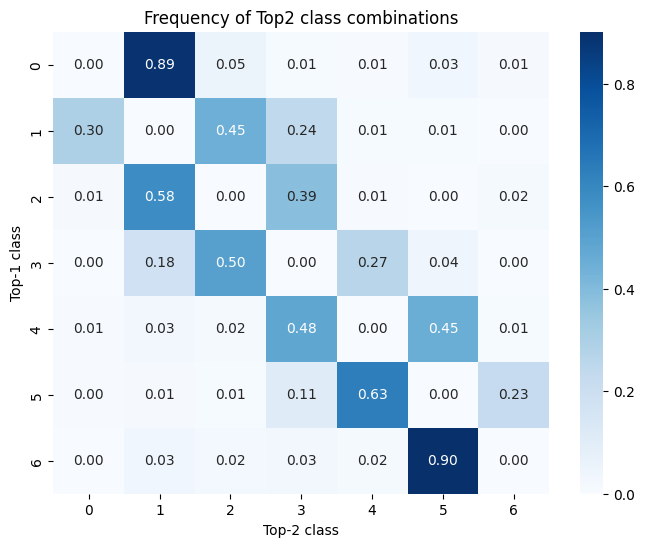

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = pair_counts.pivot(index="predicted_top1", columns="predicted_top2", values="count").fillna(0)
pivot_relative = pivot.div(pivot.sum(axis=1), axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_relative, annot=True, fmt=".2f", cmap="Blues")
plt.title("Frequency of Top2 class combinations")
plt.xlabel("Top-2 class")
plt.ylabel("Top-1 class")
plt.show()


### 2.2.3 Misclassification

In [125]:
errors_df = confusion_pairs[confusion_pairs["true_label"] != confusion_pairs["predicted_top1"]]
conf_matrix_errors = (
    errors_df
    .groupby(["true_label", "predicted_top1"])
    .size()
    .unstack(fill_value=0)
)

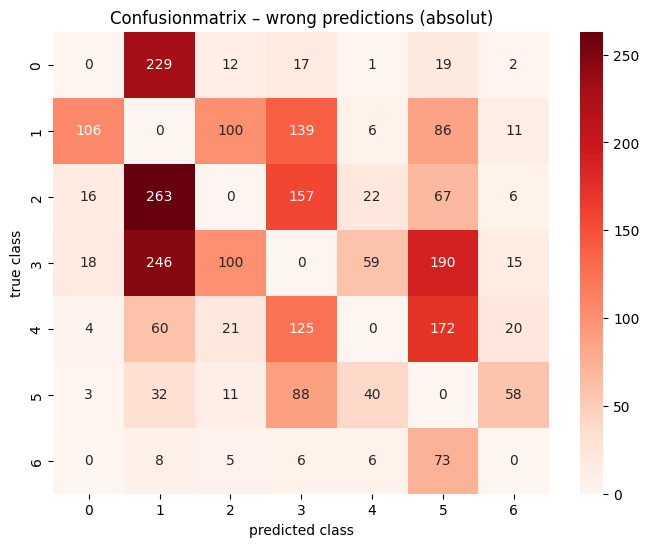

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_errors, annot=True, fmt=".0f", cmap="Reds")
plt.title("Confusionmatrix – wrong predictions (absolut)")
plt.xlabel("predicted class")
plt.ylabel("true class")
plt.show()

### 2.2.4 Connection between max(p) and entropy

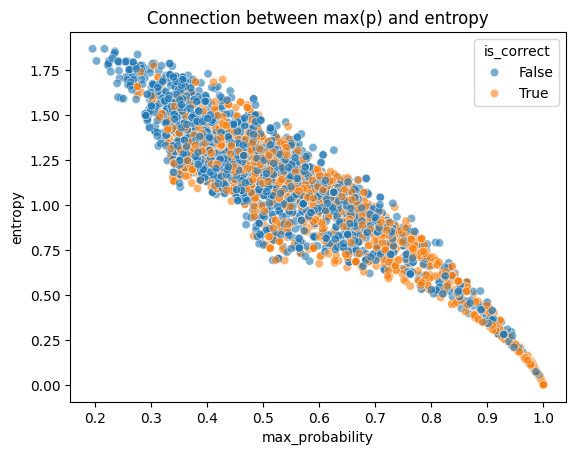

In [127]:
sns.scatterplot(data=confusion_pairs, x="max_probability", y="entropy", hue="is_correct", alpha=0.6)
plt.title("Connection between max(p) and entropy")
plt.show()

In [128]:
mask_high_conf = ((confusion_pairs["entropy"]< 0.7) & (confusion_pairs["max_probability"] > 0.5))

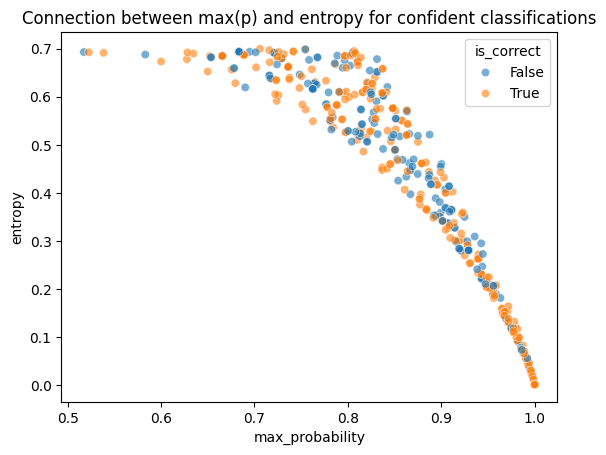

In [129]:
sns.scatterplot(data=confusion_pairs[mask_high_conf], x="max_probability", y="entropy", hue="is_correct", alpha=0.6)
plt.title("Connection between max(p) and entropy for confident classifications")
plt.show()

In [130]:
conf_and_correct = confusion_pairs[mask_high_conf]["is_correct"].mean()
print(f"Accuracy for conf. predictions: {conf_and_correct:.2%}")

Accuracy for conf. predictions: 63.45%


### 2.2.5 Uncertainty Max Probability

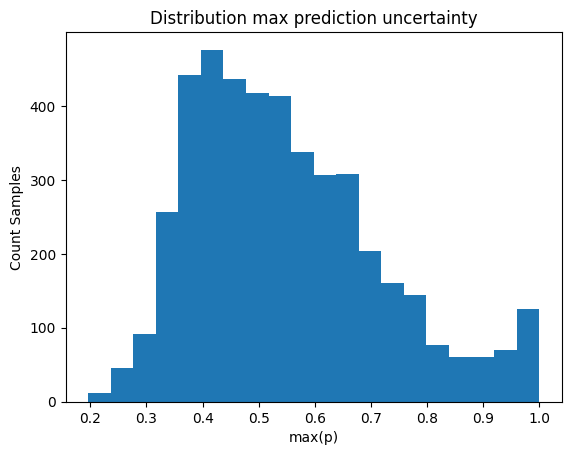

In [131]:
plt.hist(confusion_pairs["max_probability"], bins= 20)
plt.title("Distribution max prediction uncertainty")
plt.xlabel("max(p)")
plt.ylabel("Count Samples")
plt.show()

### 2.2.6 Uncertainty Entropy

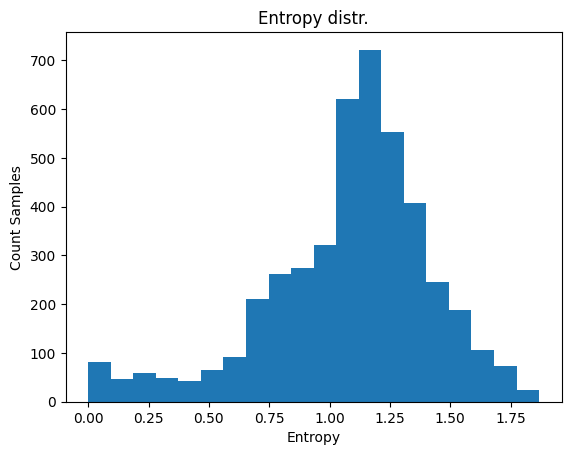

In [132]:
plt.hist(confusion_pairs["entropy"], bins= 20)
plt.title("Entropy distr.")
plt.xlabel("Entropy")
plt.ylabel("Count Samples")
plt.show()


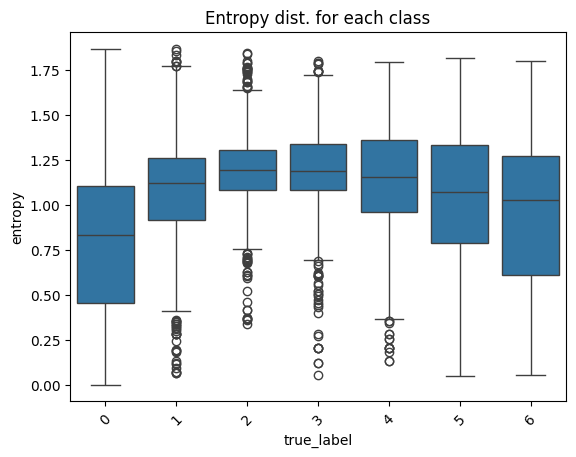

In [133]:
sns.boxplot(data=confusion_pairs, x="true_label", y="entropy")
plt.xticks(rotation=45)
plt.title("Entropy dist. for each class")
plt.show()


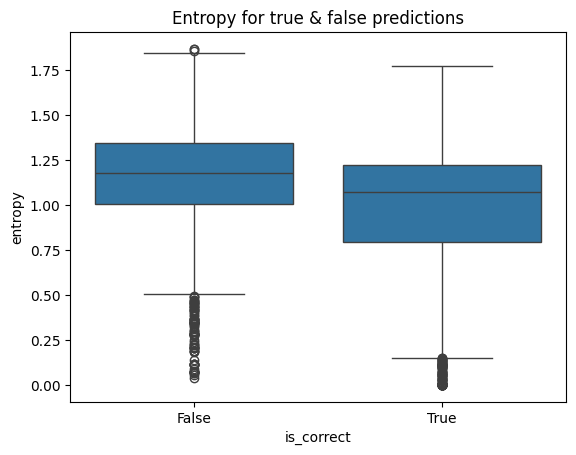

In [134]:
confusion_pairs["is_correct"] = confusion_pairs["true_label"] == confusion_pairs["predicted_top1"]

sns.boxplot(data=confusion_pairs, x="is_correct", y="entropy")
plt.title("Entropy for true & false predictions")
plt.show()


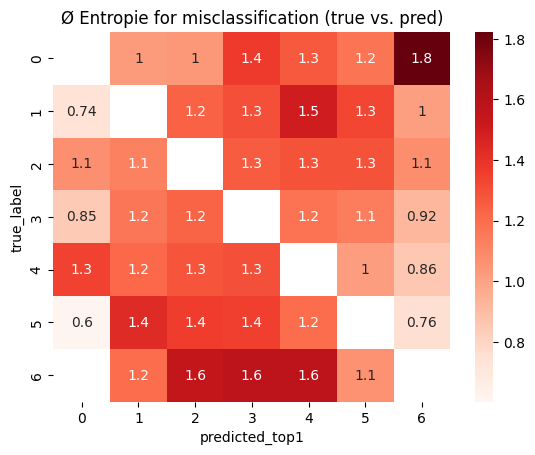

In [135]:
import numpy as np

error_only = confusion_pairs[~confusion_pairs["is_correct"]]
pivot_error_only = error_only.pivot_table(values="entropy", index="true_label", columns="predicted_top1", aggfunc="mean")

sns.heatmap(pivot_error_only, annot=True, cmap="Reds")
plt.title("Ø Entropie for misclassification (true vs. pred)")
plt.show()


# 3. MultinomialNB

## 3.1 Initial Model Pipeline

In [136]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import MultinomialNB

pipe_mnb = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ("nb", MultinomialNB())
])

## 3.2 Parameter Training

In [137]:

param_grid = {
    "nb__alpha": [1e-3, 1e-2, 0.05, 0.1, 0.3, 1.0, 3.0, 10.0]
}

gs_mnb = run_gridsearch(pipe=pipe_mnb, param_grid=param_grid, X=X_train, y=y_train, name="MultiNB")

MultiNB best params: {'nb__alpha': 0.001} | best f1: 0.3786


c:\Users\timmn\OneDrive\Dokumente\GitHub\Probabilistic-Machine-Learning_lecture-PROJECTS\projects\13-3NTXXXX_microcensus_income\venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [138]:
_ = calculate_cv(gs_mnb.best_estimator_, X_train, y_train["income"], cv, scoring)

accuracy: 0.4215 ± 0.0041
f1_macro: 0.3786 ± 0.0043
neg_log_loss: -1.6019 ± 0.0255


In [139]:
y_pred_mnb = gs_mnb.predict(X_test)
y_probs_mnb = gs_mnb.predict_proba(X_test)
mnb_eval = evaluate_model(y_pred=y_pred_mnb, y_test=y_test, model_name="MultinomialNB",y_proba=y_probs_mnb)

MultinomialNB:
Accuracy: 0.4108387677085676
Macro-F1: 0.3700812842156659
Weighted-F1: 0.3931453977091996
Log-Loss: 1.5966785128241145
              precision    recall  f1-score   support

           0       0.60      0.44      0.51       498
           1       0.49      0.64      0.55      1243
           2       0.31      0.17      0.22       641
           3       0.37      0.33      0.35       940
           4       0.29      0.12      0.17       458
           5       0.31      0.53      0.39       498
           6       0.39      0.42      0.40       169

    accuracy                           0.41      4447
   macro avg       0.39      0.38      0.37      4447
weighted avg       0.40      0.41      0.39      4447



# 4. ComplementNB

## 4.1 Initial Model Pipeline

In [140]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import ComplementNB

pipe_compnb = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ("nb", ComplementNB())
])

## 4.2 Parameter Training

In [141]:

param_grid = {
    "nb__alpha": [1e-3, 1e-2, 0.05, 0.1, 0.3, 1.0, 3.0, 10.0]
}

gs_compnb = run_gridsearch(pipe=pipe_compnb, param_grid=param_grid, X=X_train, y=y_train, name="ComplNB")

ComplNB best params: {'nb__alpha': 1.0} | best f1: 0.3332


c:\Users\timmn\OneDrive\Dokumente\GitHub\Probabilistic-Machine-Learning_lecture-PROJECTS\projects\13-3NTXXXX_microcensus_income\venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [142]:
_ = calculate_cv(gs_compnb.best_estimator_, X_train, y_train["income"], cv, scoring)

accuracy: 0.4094 ± 0.0097
f1_macro: 0.3332 ± 0.0130
neg_log_loss: -1.6753 ± 0.0081


In [143]:
y_pred_compnb = gs_compnb.predict(X_test)
y_probs_compnb = gs_compnb.predict_proba(X_test)
comp_eval = evaluate_model(y_pred=y_pred_compnb, y_test=y_test, model_name="ComplementNB",  y_proba=y_probs_compnb)

ComplementNB:
Accuracy: 0.4047672588261749
Macro-F1: 0.32560673916687266
Weighted-F1: 0.36695111056666274
Log-Loss: 1.6859166014421652
              precision    recall  f1-score   support

           0       0.51      0.42      0.46       498
           1       0.48      0.68      0.57      1243
           2       0.28      0.06      0.10       641
           3       0.40      0.30      0.34       940
           4       0.38      0.09      0.14       458
           5       0.29      0.68      0.41       498
           6       0.26      0.25      0.26       169

    accuracy                           0.40      4447
   macro avg       0.37      0.35      0.33      4447
weighted avg       0.40      0.40      0.37      4447



# 5. Comparison 

In [144]:
df_eval = pd.concat([
    catnb_eval,
    mnb_eval,
    comp_eval
    ], ignore_index = True)
df_eval

,Model,Accuracy,Macro-F1,Weighted-F1,Log-Loss
0,CategoricalNB,0.410839,0.370081,0.393145,1.597000
1,MultinomialNB,0.410839,0.370081,0.393145,1.596679
2,ComplementNB,0.404767,0.325607,0.366951,1.685917


In [ ]:
model_comparison = data_load("data/model_comparison.csv")
model_comparison = pd.concat([
    model_comparison,
    df_eval
], ignore_index=True)
model_comparison

Data loaded!


,Model,Accuracy,Macro-F1,Weighted-F1,Log-Loss
0,Random_Guess,0.131999,0.121054,0.142651,1.945910
1,Majority_Guess,0.279514,0.062415,0.122122,25.968938
2,CategoricalNB,0.410839,0.370081,0.393145,1.597000
3,MultinomialNB,0.410839,0.370081,0.393145,1.596679
4,ComplementNB,0.404767,0.325607,0.366951,1.685917


In [147]:
save_df(model_comparison, "data/model_comparison.csv")

Data saved!
